In [13]:
import numpy as np
from astroNN.datasets import load_galaxy10
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import time
import json

In [14]:
# Obtain the Galaxy10_DECals dataset
images, labels = load_galaxy10()

C:\Users\emily\.astroNN\datasets\Galaxy10_DECals.h5 was found!


In [15]:
# Print some basic information about the dataset
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

Images shape: (17736, 256, 256, 3)
Labels shape: (17736,)


In [16]:
# Normalize pixel values to range [0, 1]
images = images.astype('float32') / 255.0

In [17]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [18]:
train_class_counts = Counter(y_train)
test_class_counts = Counter(y_test)

In [19]:
# Convert labels to one-hot encoded format
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [20]:
class_names =  ['Disturbed Galaxy', 
                 'Merging Galaxy', 
                 'Round Smooth Galaxy', 
                 'In-between Round Smooth Galaxy', 
                 'Cigar Shaped Smooth Galaxy', 
                 'Barred Spiral Galaxy', 
                 'Unbarred Tight Spiral Galaxy', 
                 'Unbarred Loose Spiral Galaxy', 
                 'Edge-on Galaxy without Bulge', 
                 'Edge-on Galaxy with Bulge']

Class distribution in training set:
Class 7: 2112 samples
Class 3: 1619 samples
Class 1: 1480 samples
Class 8: 1140 samples
Class 2: 2116 samples
Class 6: 1464 samples
Class 9: 1510 samples
Class 5: 1607 samples
Class 0: 877 samples
Class 4: 263 samples

Class distribution in test set:
Class 7: 516 samples
Class 4: 71 samples
Class 2: 529 samples
Class 8: 283 samples
Class 3: 408 samples
Class 6: 365 samples
Class 9: 363 samples
Class 5: 436 samples
Class 0: 204 samples
Class 1: 373 samples


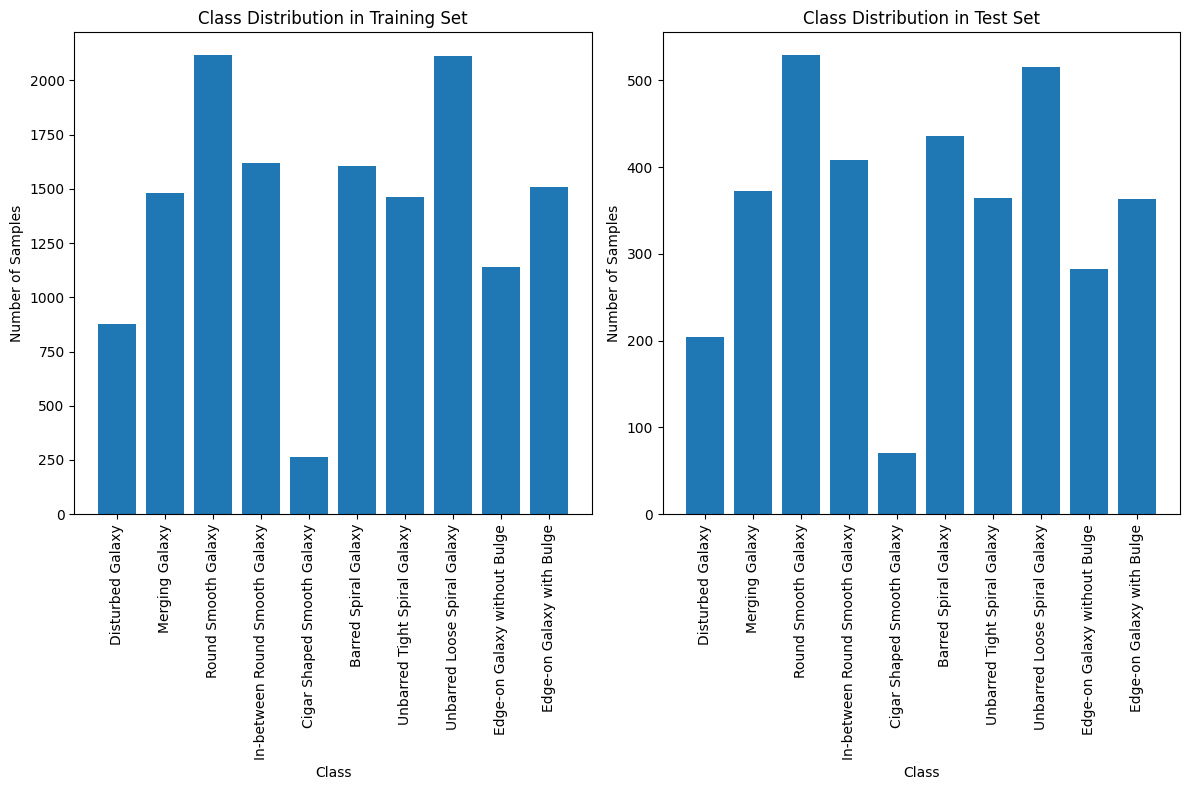

In [21]:
# Print class distribution
print("Class distribution in training set:")
for class_label, count in train_class_counts.items():
    print(f"Class {class_label}: {count} samples")

print("\nClass distribution in test set:")
for class_label, count in test_class_counts.items():
    print(f"Class {class_label}: {count} samples")

# Optional: Visualize class distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.bar(train_class_counts.keys(), train_class_counts.values())
plt.title("Class Distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(range(num_classes), class_names, rotation=90)

plt.subplot(1, 2, 2)
plt.bar(test_class_counts.keys(), test_class_counts.values())
plt.title("Class Distribution in Test Set")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(range(num_classes), class_names, rotation=90)

plt.tight_layout()
plt.show()

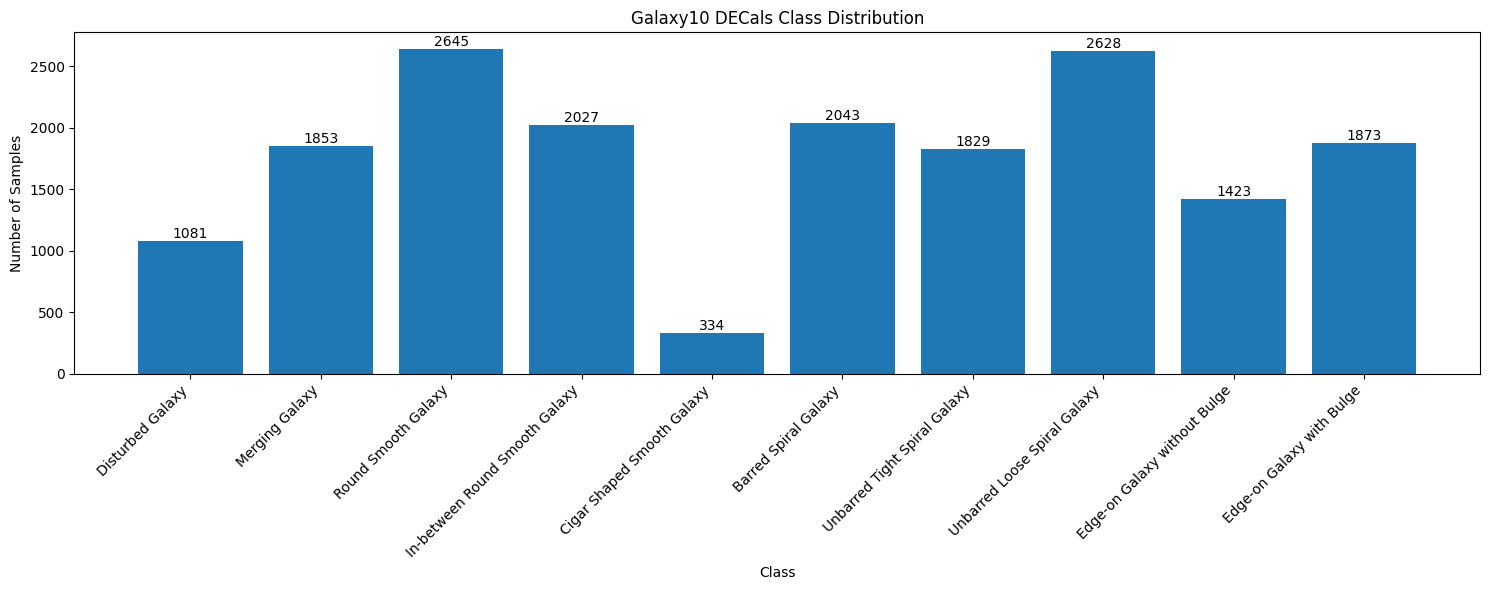

Total class distribution (Training + Test):
Disturbed Galaxy: 1081 samples
Merging Galaxy: 1853 samples
Round Smooth Galaxy: 2645 samples
In-between Round Smooth Galaxy: 2027 samples
Cigar Shaped Smooth Galaxy: 334 samples
Barred Spiral Galaxy: 2043 samples
Unbarred Tight Spiral Galaxy: 1829 samples
Unbarred Loose Spiral Galaxy: 2628 samples
Edge-on Galaxy without Bulge: 1423 samples
Edge-on Galaxy with Bulge: 1873 samples


In [22]:
import matplotlib.pyplot as plt
import numpy as np

class_names = ['Disturbed Galaxy', 
               'Merging Galaxy', 
               'Round Smooth Galaxy', 
               'In-between Round Smooth Galaxy', 
               'Cigar Shaped Smooth Galaxy', 
               'Barred Spiral Galaxy', 
               'Unbarred Tight Spiral Galaxy', 
               'Unbarred Loose Spiral Galaxy', 
               'Edge-on Galaxy without Bulge', 
               'Edge-on Galaxy with Bulge']

# Combine training and test set counts
total_class_counts = {name: train_class_counts.get(i, 0) + test_class_counts.get(i, 0) 
                      for i, name in enumerate(class_names)}

# Create the bar chart
plt.figure(figsize=(15, 6))
bars = plt.bar(range(len(class_names)), [total_class_counts[name] for name in class_names])

# Customize the chart
plt.title("Galaxy10 DECals Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height}',
             ha='center', va='bottom')

# Adjust layout and display the chart
plt.tight_layout()
plt.show()

# Print total class distribution
print("Total class distribution (Training + Test):")
for name in class_names:
    print(f"{name}: {total_class_counts[name]} samples")

In [23]:
# Print shapes of the resulting datasets
print(f"Training images shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing images shape: {X_test.shape}")
print(f"Testing labels shape: {y_test.shape}")

Training images shape: (14188, 256, 256, 3)
Training labels shape: (14188, 10)
Testing images shape: (3548, 256, 256, 3)
Testing labels shape: (3548, 10)


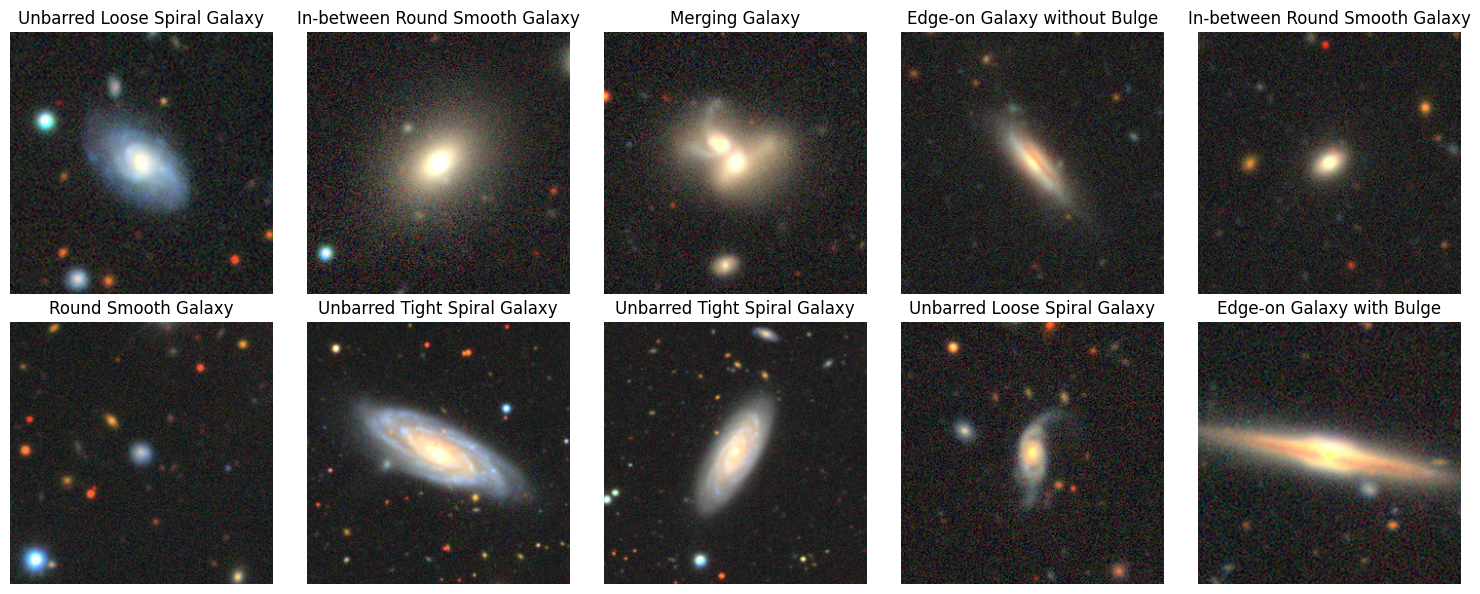

In [24]:
# View some images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i])
    ax.set_title(f"{class_names[np.argmax(y_train[i])]}")
    #title(class_names[np.argmax(sample_labels[i])]
    ax.axis('off')
plt.tight_layout()
plt.show()

In [25]:
input_shape=(256, 256, 3)
model1 = models.Sequential([
    # Data Augmentation Layers
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
    
    # CNN Layers
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])
model1.save('model1.keras')

C:\Users\emily\anaconda3\envs\astrotest2\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
C:\Users\emily\anaconda3\envs\astrotest2\Lib\site-packages\keras\src\saving\saving_api.py:102: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.


In [6]:
input_shape=(256, 256, 3)
model1 = Sequential([
    # Data Augmentation Layers
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomTranslation(height_factor=0.2, width_factor=0.2),
    
    # CNN Layers
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

NameError: name 'RandomFlip' is not defined

In [ ]:
input_shape=(256, 256, 3)
model2 = Sequential([
    Conv2D(filters=8, kernel_size=10, padding='same', input_shape=input_shape, activation='relu'),
    Conv2D(filters=8, kernel_size=10, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=16, kernel_size=5, padding='same', activation='relu'),
    Conv2D(filters=16, kernel_size=5, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
    Dropout(rate=0.5),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

In [26]:
model1.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ ?                      │   0 (unbuilt) │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation              │ ?                      │   0 (unbuilt) │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Train the Model
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
print("Training Start!")
start = time.time()
history = model1.fit(X_train, y_train, 
                    epochs=50, 
                    batch_size=64, 
                    validation_split=0.2,
                    callbacks=[early_stopping]
                   )
print("Total time: ", time.time() - start, "seconds")

Training Start!
Epoch 1/50
 12/178 ━━━━━━━━━━━━━━━━━━━━ 1:22 496ms/step - accuracy: 0.1175 - loss: 2.9668

KeyboardInterrupt: 

In [28]:
model1.save('model1.keras')

In [19]:
# Train the Model
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
print("Training Start!")
start = time.time()
history = model1.fit(X_train, y_train, 
                    epochs=50, 
                    batch_size=64, 
                    validation_split=0.2,
                    callbacks=[early_stopping]
                   )
print("Total time: ", time.time() - start, "seconds")

Training Start!
Epoch 1/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 93s 492ms/step - accuracy: 0.1599 - loss: 2.2776 - val_accuracy: 0.2357 - val_loss: 2.0272
Epoch 2/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 79s 442ms/step - accuracy: 0.2218 - loss: 2.0663 - val_accuracy: 0.2287 - val_loss: 1.9992
Epoch 3/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 79s 441ms/step - accuracy: 0.2412 - loss: 2.0266 - val_accuracy: 0.2484 - val_loss: 1.9199
Epoch 4/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 79s 442ms/step - accuracy: 0.2411 - loss: 1.9924 - val_accuracy: 0.2533 - val_loss: 1.8806
Epoch 5/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 80s 449ms/step - accuracy: 0.2564 - loss: 1.9437 - val_accuracy: 0.2734 - val_loss: 1.8660
Epoch 6/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 79s 445ms/step - accuracy: 0.2640 - loss: 1.9531 - val_accuracy: 0.2600 - val_loss: 1.9252
Epoch 7/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 79s 443ms/step - accuracy: 0.2554 - loss: 1.9475 - val_accuracy: 0.3175 - val_loss: 1.8195
Epoch 8/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 79s 444ms/step - accuracy: 

In [20]:
# Evaluate Performance
test_loss, test_accuracy = model1.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.5938 - loss: 1.1568
Test accuracy: 0.6034


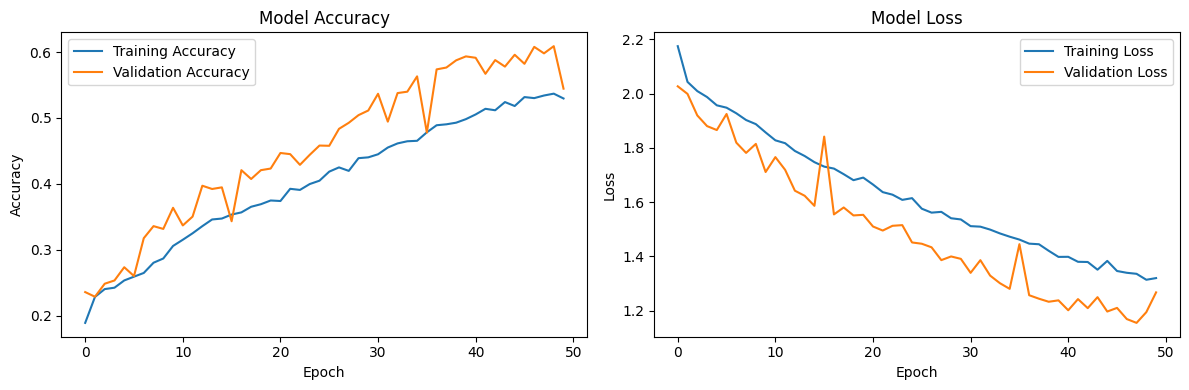

In [21]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step


C:\Users\emily\anaconda3\envs\astrotest1\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
C:\Users\emily\anaconda3\envs\astrotest1\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
C:\Users\emily\anaconda3\envs\astrotest1\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


                                precision    recall  f1-score   support

              Disturbed Galaxy       0.00      0.00      0.00       204
                Merging Galaxy       0.65      0.42      0.51       373
           Round Smooth Galaxy       0.71      0.89      0.79       529
In-between Round Smooth Galaxy       0.62      0.75      0.68       408
    Cigar Shaped Smooth Galaxy       0.50      0.01      0.03        71
          Barred Spiral Galaxy       0.54      0.45      0.49       436
  Unbarred Tight Spiral Galaxy       0.63      0.49      0.55       365
  Unbarred Loose Spiral Galaxy       0.42      0.66      0.51       516
  Edge-on Galaxy without Bulge       0.78      0.70      0.74       283
     Edge-on Galaxy with Bulge       0.68      0.80      0.74       363

                      accuracy                           0.60      3548
                     macro avg       0.55      0.52      0.50      3548
                  weighted avg       0.58      0.60      0.58 

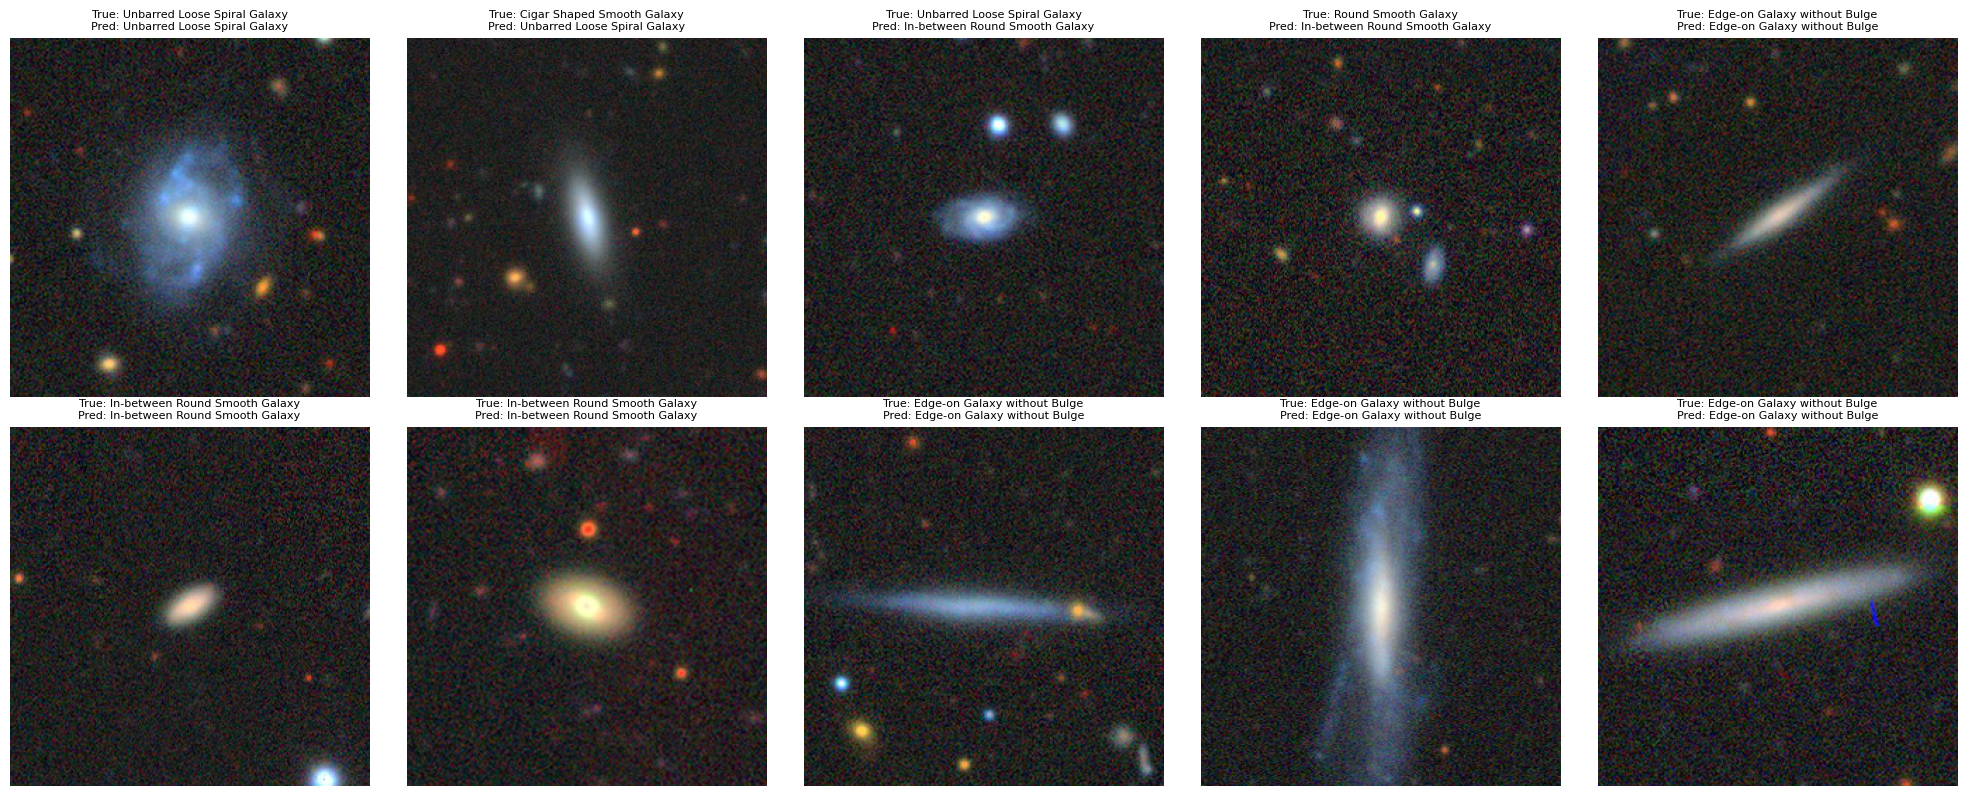

In [22]:
# Make predictions on test set
y_pred = model1.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Print classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

# Visualize a few images with predictions
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[i])
    true_label = class_names[y_true_classes[i]]
    pred_label = class_names[y_pred_classes[i]]
    ax.set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=8)
    ax.axis('off')
plt.tight_layout()
plt.show()

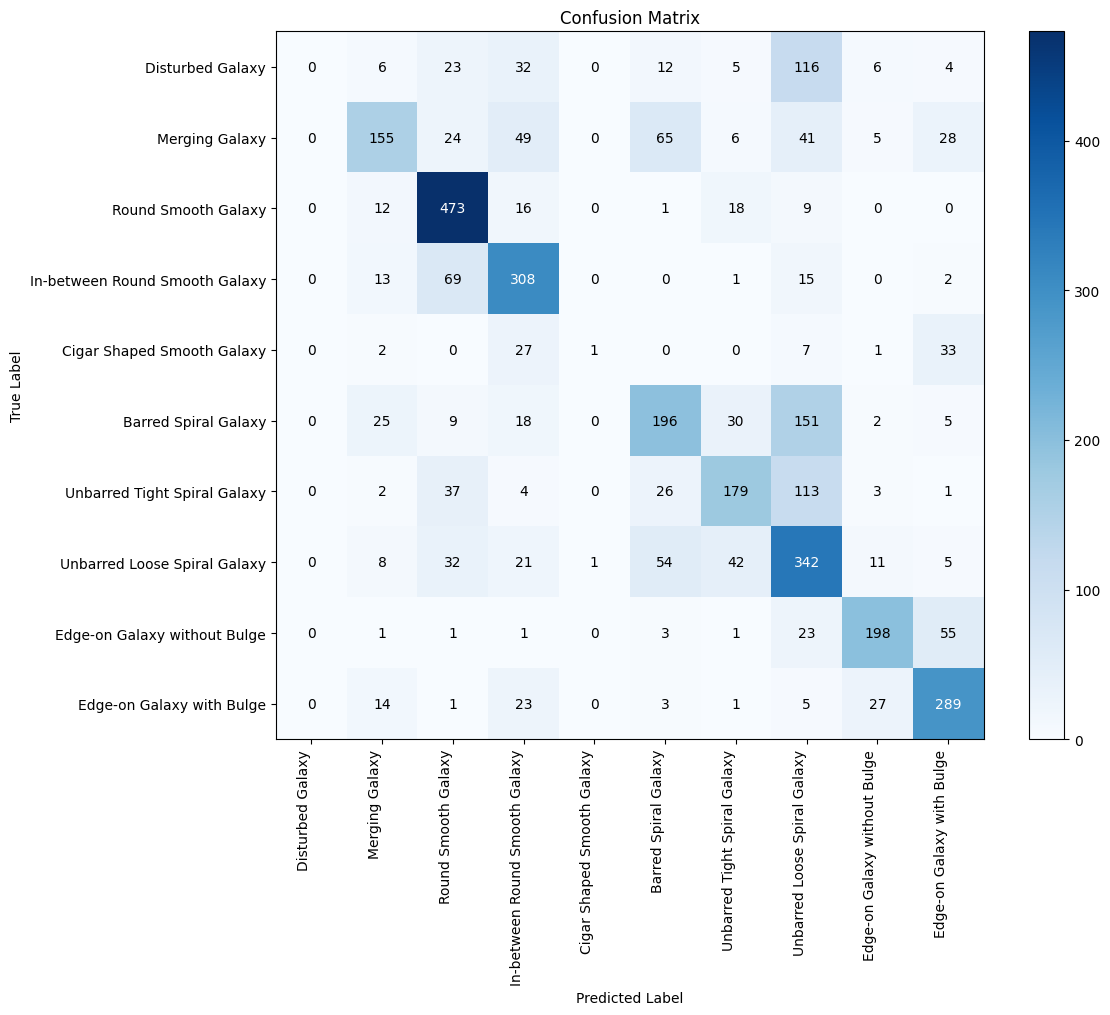

In [23]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Create a figure for the confusion matrix
fig, ax = plt.subplots(figsize=(12, 10))

# Create the heatmap
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

# Add title and labels
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

# Add tick marks and labels
tick_marks = np.arange(len(class_names))
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels(class_names, rotation=90, ha='right')
ax.set_yticklabels(class_names)

# Add colorbar
plt.colorbar(im)

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()